# Lab 3 - Convergence analysis of the upwind scheme

### Tomasz Ogiołda

## Goal

The goal of the convergence analysis is to evaluate the accuracy of a numerical solution as the resolution of the discretization is refined. Specifically, the analysis will explore spatial convergence (how the solution improves with decreasing grid spacing dx).

## Setup

The problem involves the advection of an initial condition (represented by a Gaussian function) over time. The numerical method used to solve this advection equation is the upwind scheme, which is an explicit finite difference method. For stability, we will maintain a constant Courant number (CFL), ensuring that the time step dt and spatial step dx are related according to the CFL condition:

$$C= v \cdot \frac{\Delta t}{\Delta x}$$

In the following analysis we'll consider constants of Courant numer. Keeping the CFL constant per analysis allows us to maintain a consistent physical representation across different grid resolutions.

The error will be quantified using the Root Mean Square Error (RMSE):

$$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( u_i^{\text{num}} - u_i^{\text{exact}} \right)^2}$$



In [38]:
import numpy as np
from matplotlib import pyplot as plt

In [39]:
def rmse(actual: np.ndarray, expected: np.ndarray):
    assert len(actual) == len(expected), "Actual and Expected value len not matched"
    
    return np.sqrt(((actual - expected)**2).mean())

In [40]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25

    def __call__(self, x) -> float:
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

class SliceStep:
    def __init__(self, step) -> None:
        self.step = step
    
    def __radd__(self, o: slice):
        return slice(o.start + self.step, o.stop + self.step)
    
    def __rsub__(self, o: slice):
        return slice(o.start - self.step, o.stop - self.step)
    
    
def Flux(psi_l, psi_r, C):
    return (C + np.abs(C)) / 2 * psi_l + (C - np.abs(C)) / 2 * psi_r

In [41]:
time_steps = 20
nx = 100
u = -1
t_max = 45

psi_0 = Psi_0()

def upwind_scheme(x: float, C):
    psi = psi_0(x)

    i = slice(1, nx - 2)

    for _ in range(time_steps):
        one = SliceStep(1)
        adv = -(Flux(psi[i], psi[i + one], C) - Flux(psi[i - one], psi[i], C))
        psi[i] = psi[i] + adv
        
    return psi

def exact_solution(x):
    return psi_0(x - u * t_max)

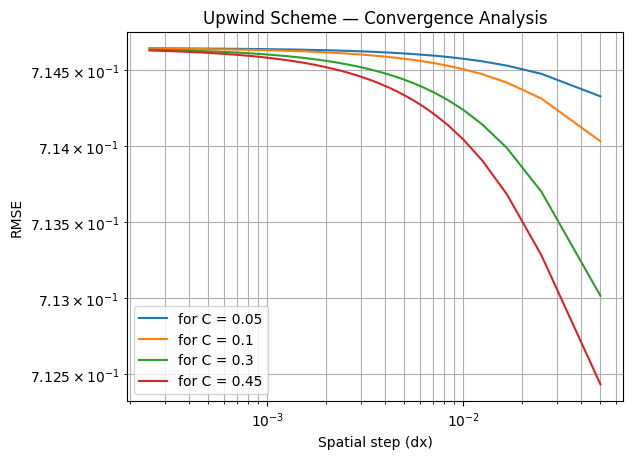

In [57]:
spacial_steps = 20
max_space = 1
nxs = spacial_steps * np.arange(start=1, stop=200)
dxs = [max_space / Nx for Nx in nxs]

def upwind_err(nx, C):
    x = np.linspace(0, max_space, nx)
    exact = exact_solution(x)
    numerical = upwind_scheme(x, C)
    
    return rmse(actual=numerical, expected=exact)

errs1 = []
errs2 = []
errs3 = []
errs4 = []

for (nx, dx) in zip(nxs, dxs):
    errs1.append(upwind_err(nx, 0.05))
    errs2.append(upwind_err(nx, 0.1))
    errs3.append(upwind_err(nx, 0.3))
    errs4.append(upwind_err(nx, 0.45))
    
plt.loglog(dxs, errs1, label='for C = 0.05')
plt.loglog(dxs, errs2, label='for C = 0.1')
plt.loglog(dxs, errs3, label='for C = 0.3')
plt.loglog(dxs, errs4, label='for C = 0.45')
plt.title("Upwind Scheme — Convergence Analysis")
plt.xlabel('Spatial step (dx)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, which='both')

## Conclusions 

Decreasing the spatial step (dx) in the upwind scheme consistently reduces numerical error across all Courant numbers, confirming first-order convergence behavior. However, this relationship varies significantly with different Courant numbers, with higher values (particularly C = 0.45) showing more efficient error reduction as dx decreases. While grid refinement improves accuracy, diminishing returns are observed at very small spatial steps (dx < 10^-3), indicating that computational efficiency should be balanced against desired accuracy when selecting discretization parameters.
